# Evaluating Customer Service through Sentiment Analysis:
<img src="https://static.hosteltur.com/web/uploads_c/2016/10/B_f3a645c8d3d4e56e4fd8fc121100d6c6.jpg">
In this notebook we will perform an in depth analysis as to how organizations deal with customer complaints. <b>Customer service </b> is an essential part of any organization since it help develop a customer base. Our main aim is to implement a <b>sentiment analysis </b> with the main customer service issues with some of the organizations. We want to determine what is the <b> opinion </b>  "out there" of the main issues and "recommend" several solutions to improve this <b> sentiment </b> some customers have towards a specific final institution.

### Main goals: 
<ul>
<li>Determine the top companies that received more <b>disputes</b>. </li>
<li>Is the trend of disputes increasing or decreasing? </li>
<li> What is the overall <b>sentiment </b> of the issues? </li>
<li>What is the sentiment for the top organizations that have disputes with regards to the issues declared by the customer </li>
</ul>

**Note:** This notebook is in the process of update. Stay tuned!

In [59]:
import numpy as np 
import pandas as pd 
import sqlite3
!pip install wordcloud
!pip install chart-studio
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# Plotly libraries
import chart_studio.plotly as py
import plotly.tools as tls
#import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

#This code sets up the environment for data analysis and visualization, importing essential libraries for handling data, plotting, and generating word clouds, and initializes Plotly for interactive plotting in a Jupyter notebook.
# Any results you write to the current directory are saved as output.

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
df = pd.read_csv("consumer_complaints.csv")
df.head()
#This line of code loads a CSV file named `consumer_complaints.csv` from the specified directory into a Pandas DataFrame named `df` and displays the first five rows of the dataset using the `head()` method.

C:\Users\riyaa\AppData\Local\Temp\ipykernel_11340\1461720888.py:1: DtypeWarning:

Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.



,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [61]:
p_product_discussions = round(df["product"].value_counts() / len(df["product"]) * 100,2)

print(p_product_discussions)

labels = list(p_product_discussions.index)
values = p_product_discussions.values.tolist()
colors = ['#F78181', '#F5A9BC', '#2E9AFE', '#58FA58', '#FAAC58', '#088A85', '#8A0808', '#848484', '#F781F3', '#D7DF01', '#2E2EFE']


product_pie = go.Pie(labels=labels, values=values, 
                          marker=dict(colors=colors,
                         line=dict(color='#000000', width=2)))

layout = go.Layout(title='Product Types')

fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)
#This code calculates the percentage distribution of different product types in the `product` column of the DataFrame and then creates a pie chart to visualize this distribution using Plotly. The pie chart is customized with specific colors for each product type, and the chart is displayed interactively in the notebook with the title "Product Types."

product
Mortgage                   33.54
Debt collection            18.18
Credit reporting           16.52
Credit card                11.96
Bank account or service    11.25
Consumer Loan               3.78
Student loan                2.85
Payday loan                 0.70
Money transfers             0.69
Prepaid card                0.44
Other financial service     0.10
Name: count, dtype: float64


In [62]:
df['company_response_to_consumer'].value_counts()
#This line of code counts the occurrences of each unique value in the `company_response_to_consumer` column of the DataFrame `df`. It then returns a Series object displaying the count of each response type, sorted in descending order by default. This helps to understand how companies typically respond to consumer complaints.

company_response_to_consumer
Closed with explanation            404293
Closed with non-monetary relief     70237
Closed with monetary relief         38262
Closed without relief               17909
Closed                              13399
Closed with relief                   5305
In progress                          3763
Untimely response                    2789
Name: count, dtype: int64

In [63]:
# Building the variables for our graphs.This code creates variables to analyze and visualize the distribution of consumer disputes, company responses, and the top 5 companies with the most and least disputed complaints.
disputed = df['consumer_disputed?'].value_counts()
company_response = df['company_response_to_consumer'].value_counts()
top5_disputed = df['company'].loc[df['consumer_disputed?'] == 'Yes'].value_counts()[:5]
top5_nodispute = df['company'].loc[df['consumer_disputed?'] == 'No'].value_counts()[:5]

In [64]:

# This code creates a multi-panel bar chart using Plotly to visualize various aspects of consumer complaints: the overall dispute distribution, the top 5 companies with the most and least disputes, and company responses, arranging them in a 2x3 grid layout with an overarching title "Sectors" and interactive features.
total_complaints_plotly = go.Bar(
            x=disputed.index.values,
            y=disputed.values,
    text = 'Complaints',
    showlegend=False,
    marker=dict(
        color=['#40FF00', '#FF0000'])
    )

top5_disputes_plotly = go.Bar(
            x=top5_disputed.index.values,
            y=top5_disputed.values,
    text='Disputes',
    showlegend=False,
    marker=dict(
        color=top5_disputed.values,
        colorscale='Reds')
    )

top5_nodisputes_plotly = go.Bar(
            x=top5_nodispute.index.values,
            y=top5_nodispute.values,
    text='No Disputes',
    showlegend=False,
    marker=dict(
        color=top5_nodispute.values,
        colorscale='Blues')
    )

# Lower Subplot
customer_res_plotly = go.Bar(
            x=company_response.index.values,
            y=company_response.values,
    text='Customer Response',
    showlegend=False,
        marker=dict(
        color=df['company_response_to_consumer'].value_counts().values,
        colorscale = [[0.0, 'rgb(165,0,38)'], [0.1111111111111111, 'rgb(215,48,39)'], [0.2222222222222222, 'rgb(244,109,67)'], 
                      [0.3333333333333333, 'rgb(253,174,97)'], [0.4444444444444444, 'rgb(254,224,144)'], 
                      [0.5555555555555556, 'rgb(224,243,248)'], [0.6666666666666666, 'rgb(171,217,233)'], 
                      [0.7777777777777778, 'rgb(116,173,209)'], [0.8888888888888888, 'rgb(69,117,180)'], 
                      [1.0, 'rgb(49,54,149)']],
        reversescale = True
        )
)

fig = tls.make_subplots(rows=2, cols=3, specs=[[{}, {}, {}], [{'colspan': 3}, None, None]],
                          subplot_titles=('Did the Customer Disputed?',
                                          'Disputes',
                                         'No Disputes',
                                         'Customer Response'))

# First three Subplots
fig.append_trace(total_complaints_plotly, 1, 1)
fig.append_trace(top5_disputes_plotly , 1, 2)
fig.append_trace(top5_nodisputes_plotly , 1, 3)

# Lower Subplot
fig.append_trace(customer_res_plotly, 2, 1)



fig['layout'].update(showlegend=True, height=600, width=800, title='Sectors')
iplot(fig, filename='Complaints')

C:\Users\riyaa\AppData\Roaming\Python\Python310\site-packages\plotly\tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [65]:
df['date_received'] = pd.to_datetime(df['date_received'])
df['year_received'], df['month_received'] = df['date_received'].dt.year, df['date_received'].dt.month
df.head()
#This code converts the date_received column in the DataFrame df to a datetime format, extracts the year and month from each date, and creates two new columns, year_received and month_received, to store these values.

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,year_received,month_received
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074,2013,8
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080,2013,8
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473,2013,8
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326,2013,8
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067,2013,8


In [66]:
# Create a Line Plot by the top 5 companies  by year who had more customer interaction cases (Disputes and No Disputes)
#This code groups the DataFrame by year and dispute status, counts the occurrences of each company within those groups, and then isolates the data for the top 5 companies with disputes. It prepares the data for creating a line plot by extracting the years associated with disputes for these top companies.
sorting_groups = df.groupby(['year_received', 'consumer_disputed?'])['company'].apply(lambda x: x.value_counts())
d = {'CRM': sorting_groups}


year_crm = pd.DataFrame(data=d).reset_index()
year_crm.sort_values(by='CRM', ascending=False)

crm_df = year_crm.rename(columns={"level_2": "company"})

# Conditionals Top 5 Companies with dispues (Bank of America, Wells Fargo, JP Morgan, Equifax, CitiBank)
boa_disputes = crm_df.loc[(crm_df['company'] == 'Bank of America') & (crm_df['consumer_disputed?'] == 'Yes')]
wfc_disputes = crm_df.loc[(crm_df['company'] == 'Wells Fargo & Company') & (crm_df['consumer_disputed?'] == 'Yes')]
jp_disputes = crm_df.loc[(crm_df['company'] == 'JPMorgan Chase & Co.') & (crm_df['consumer_disputed?'] == 'Yes')]
equi_disputes = crm_df.loc[(crm_df['company'] == 'Equifax') & (crm_df['consumer_disputed?'] == 'Yes')]
citi_disputes = crm_df.loc[(crm_df['company'] == 'Citibank') & (crm_df['consumer_disputed?'] == 'Yes')]

# Establish the year (Continue Here tomorrow!)
years = boa_disputes['year_received'].values.tolist()

In [67]:
#This code creates and plots a line chart to visualize the number of disputes over time for the top 5 companies with the most complaints. Each company's disputes are shown as a separate line on the chart, with hover text displaying the number of disputes for each year. The chart is displayed with a title "Number of Disputes (Top 5 Companies)" and axes labeled accordingly.
crm_df.head()

,year_received,consumer_disputed?,company,CRM
0,2011,No,Bank of America,432
1,2011,No,JPMorgan Chase & Co.,298
2,2011,No,Citibank,255
3,2011,No,Capital One,201
4,2011,No,Wells Fargo & Company,170


In [68]:
# Implementing line chart (top 5 companies with complaints)
#This code creates and plots a line chart to visualize the number of disputes over time for the top 5 companies with the most complaints. Each company's disputes are shown as a separate line on the chart, with hover text displaying the number of disputes for each year. The chart is displayed with a title "Number of Disputes (Top 5 Companies)" and axes labeled accordingly.
boa_disputes_amount = boa_disputes['CRM'].values.tolist()
wfc_disputes_amount = wfc_disputes['CRM'].values.tolist()
jp_disputes_amount = jp_disputes['CRM'].values.tolist()
equi_disputes_amount = equi_disputes['CRM'].values.tolist()
citi_disputes_amount = citi_disputes['CRM'].values.tolist()

# Text to add
boa_text = [str(dis) + '\n Disputes'  for dis in boa_disputes_amount]
wfc_text = [str(wfc) + '\n Disputes'  for wfc in wfc_disputes_amount]
jp_text = [str(jp) + '\n Disputes' for jp in jp_disputes_amount]
equi_text = [str(equi) + '\n Disputes' for equi in equi_disputes_amount]
citi_text = [str(citi) + '\n Disputes' for citi in citi_disputes_amount]

boa_disputes_chart = go.Scatter(
    x=years,
    y=boa_disputes_amount,
    text=boa_text,
    name='Bank of America', 
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(0, 22, 235)',
             ),
    fill='tonexty'
)

wfc_disputes_chart = go.Scatter(
    x=years,
    y=wfc_disputes_amount,
    text=wfc_text,
    name="Wells Fargo & Company", 
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(275, 170, 0)',
             ),
    fill='tonexty'
)


jp_disputes_chart = go.Scatter(
    x=years,
    y=jp_disputes_amount,
    text=jp_text,
    name='JP Morgan Chase & Co.',
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(128, 128, 128)',
             ),
    fill='tonexty'
)

equi_disputes_chart = go.Scatter(
    x=years,
    y=equi_disputes_amount,
    text=equi_text,
    name='Equifax',
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(175, 0, 0)',
             ),
    fill='tonexty'
)

citi_disputes_chart = go.Scatter(
    x=years,
    y=citi_disputes_amount,
    text=citi_text,
    name='CitiBank',
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(0, 215, 215)',
             ),
    fill='tonexty'
)

data = [boa_disputes_chart, wfc_disputes_chart, jp_disputes_chart, equi_disputes_chart, citi_disputes_chart]

layout = dict(title = 'Number of Disputes <br> (Top 5 Companies)',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Number of Disputes')
             )


fig = dict(data=data, layout=layout)


iplot(fig, filename='basic-area-no-bound')

In [69]:
# Months with the highest disputes (We will make a barplot)
#This code defines a function customerservice_per_month to filter the DataFrame based on the month and dispute status. It then calculates the number of disputes and non-disputes for each month of the year, storing the counts in variables for use in further analysis or plotting.
def customerservice_per_month(month, dispute):
    result = df.loc[(df['month_received'] == month) & (df['consumer_disputed?'] == dispute)]
    return result

# Monthly Disputes
dis_january = len(customerservice_per_month(month=1, dispute='Yes'))
dis_february = len(customerservice_per_month(month=2, dispute='Yes'))
dis_march = len(customerservice_per_month(month=3, dispute='Yes'))
dis_april = len(customerservice_per_month(month=4, dispute='Yes'))
dis_may = len(customerservice_per_month(month=5, dispute='Yes'))
dis_june = len(customerservice_per_month(month=6, dispute='Yes'))
dis_july = len(customerservice_per_month(month=7, dispute='Yes'))
dis_august = len(customerservice_per_month(month=8, dispute='Yes'))
dis_september = len(customerservice_per_month(month=9, dispute='Yes'))
dis_october = len(customerservice_per_month(month=10, dispute='Yes'))
dis_november = len(customerservice_per_month(month=11, dispute='Yes'))
dis_december = len(customerservice_per_month(month=12, dispute='Yes'))

# Monthly No-Disputes
nodis_january = len(customerservice_per_month(month=1, dispute='No'))
nodis_february = len(customerservice_per_month(month=2, dispute='No'))
nodis_march = len(customerservice_per_month(month=3, dispute='No'))
nodis_april = len(customerservice_per_month(month=4, dispute='No'))
nodis_may = len(customerservice_per_month(month=5, dispute='No'))
nodis_june = len(customerservice_per_month(month=6, dispute='No'))
nodis_july = len(customerservice_per_month(month=7, dispute='No'))
nodis_august = len(customerservice_per_month(month=8, dispute='No'))
nodis_september = len(customerservice_per_month(month=9, dispute='No'))
nodis_october = len(customerservice_per_month(month=10, dispute='No'))
nodis_november = len(customerservice_per_month(month=11, dispute='No'))
nodis_december = len(customerservice_per_month(month=12, dispute='No'))

In [70]:
# Most active months
#This code creates a side-by-side bar chart to compare the number of disputes and non-disputes for each month. It uses Plotly to generate two horizontal bar charts—one for disputes and one for non-disputes—arranged in a 1x2 subplot layout, with the title "Level of Activity by Month" and customized colors and markers.
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
         'October', 'November', 'December']
disputes_by_month = [dis_january, dis_february, dis_march, dis_april, dis_may, dis_june, dis_july, dis_august, dis_september,
                    dis_october, dis_november, dis_december]

nodisputes_by_month = [nodis_january, nodis_february, nodis_march, nodis_april, nodis_may, nodis_june, nodis_july, 
                       nodis_august, nodis_september, nodis_october, nodis_november, nodis_december]


disputes_chart = go.Bar(
    y=months,
    x=disputes_by_month,
    orientation='h',
    name='Disputes',
    text='Disputes',
    marker=dict(
        color='#FF6464',
    line=dict(
        color='#CD3232',
        width=1.5
    ))
)

nodisputes_chart = go.Bar(
    y=months,
    x=nodisputes_by_month,
    orientation='h',
    name='No Disputes',
    text='No Disputes',
    marker=dict(
        color='#A9FFA9',
    line=dict(
        color='#59AF59',
        width=1.5
    ))
)

fig = tls.make_subplots(rows=1, cols=2, specs=[[{}, {}]],
                          subplot_titles=('Dispute Chart per Month',
                                          'No Dispute Chart per Month'))

fig.append_trace(disputes_chart, 1, 1)
fig.append_trace(nodisputes_chart, 1, 2)

fig['layout'].update(showlegend=True, title="Level of Activity by Month")
iplot(fig)

C:\Users\riyaa\AppData\Roaming\Python\Python310\site-packages\plotly\tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [71]:
pip install --upgrade wordcloud pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
#This code generates two word clouds to visualize the most common issues in consumer disputes versus non-disputes. It creates word clouds for both categories using the WordCloud library, then plots them side by side with matplotlib to compare the main issues associated with disputed and non-disputed complaints. Main Issue in Disputes
disputes_issue = df['issue'].loc[df['consumer_disputed?'] == 'Yes']

disputed_wordcloud = WordCloud(
    background_color='black',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40, 
    random_state=42
    ).generate(' '.join(df['issue'].loc[df['consumer_disputed?'] == 'Yes']))

nodispute_wordcloud = WordCloud(
    background_color='black',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40, 
    random_state=42
    ).generate(' '.join(df['issue'].loc[df['consumer_disputed?'] == 'No']))

# Issue wordclouds with and without disputes subplots
fig = plt.figure(figsize=(16,8))
fig.add_subplot(221)
plt.imshow(disputed_wordcloud, interpolation='bilinear')
plt.title('Main Issues with Disputes', fontsize=16)
plt.axis('off')

fig.add_subplot(222)
plt.imshow(nodispute_wordcloud, interpolation='bilinear')
plt.title('Main Issues without Disputes', fontsize=16)
plt.axis('off')
plt.show()


ValueError: Only supported for TrueType fonts

ValueError: Only supported for TrueType fonts

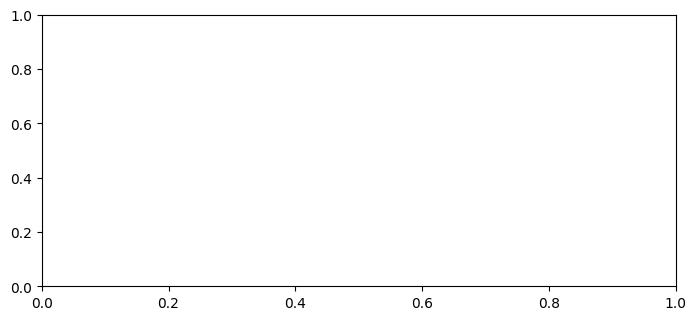

In [ ]:
#This code generates and plots five word clouds in a 3x2 grid layout to visualize the most common issues reported in disputes for each of the top 5 companies. Each subplot shows a word cloud for a specific company's disputed issues, using a red background color for distinction and setting parameters to enhance word visibility.
boa_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "Bank of America")]
wfc_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "Wells Fargo & Company")]
jpm_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "JPMorgan Chase & Co.")] 
equi_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "Equifax")]
citi_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "Citibank")]


# Create Subplots of Wordclouds
fig = plt.figure(figsize=(18,12))

# First Subplot
plt.subplot(3, 2, 1)
boa_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(boa_dis)
)

plt.imshow(boa_disputed_wordcloud)
plt.title('Bank of America Disputes', fontsize=16)
plt.axis('off')

# Second Subplot
plt.subplot(3, 2, 2)
wfc_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(wfc_dis)
)

plt.imshow(wfc_disputed_wordcloud)
plt.title('Wells Fargo & Company Disputes', fontsize=16)
plt.axis('off')

plt.subplot(3, 2, 3)
jpm_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(jpm_dis)
)

plt.imshow(jpm_disputed_wordcloud)
plt.title('JP Morgan Chase & Co.', fontsize=16)
plt.axis('off')


plt.subplot(3, 2, 4)
equi_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(equi_dis)
)

plt.imshow(equi_disputed_wordcloud)
plt.title('Equifax', fontsize=16)
plt.axis('off')

plt.subplot(3, 2, 5)
citi_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(citi_dis)
)

plt.imshow(citi_disputed_wordcloud)
plt.title('CitiBank', fontsize=16)
plt.axis('off')

In [ ]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,year_received,month_received
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074,2013,8
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080,2013,8
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473,2013,8
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326,2013,8
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067,2013,8


In [ ]:
#This code filters the DataFrame to include only rows where the consumer_disputed? column is 'Yes', then creates a cross-tabulation of dispute occurrences by state and company. It calculates the percentage distribution of disputes across different companies within each state by normalizing the counts.
dispute_presence = df.loc[df['consumer_disputed?'] == 'Yes']
cross_month = pd.crosstab(dispute_presence['state'], dispute_presence['company']).apply(lambda x: x/x.sum() * 100)

In [ ]:
#  Share of Most disputes for Bank of America.
#This code creates a choropleth map to visualize the share of complaints for Bank of America by state. It uses Plotly to generate a map with varying shades of color representing the percentage of complaints in each state, with a custom color scale and a color bar to indicate the percentage range. The map is displayed with a title "Most Complaints by State <br> Bank of America" and includes additional styling for the map's appearance.
df_boa = pd.DataFrame(cross_month['Bank of America']).reset_index().sort_values(by="Bank of America", ascending=False).round(2)
df_boa = df_boa.rename(columns={'Bank of America': 'share of complaints'})

for col in df_boa.columns:
    df_boa[col] = df_boa[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_boa['text'] = "State Code: " + df_boa['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_boa['state'],
        z = df_boa['share of complaints'], 
        locationmode = 'USA-states',
        text = df_boa['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> Bank of America',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [ ]:
#This code generates a choropleth map to visualize the share of complaints for Wells Fargo & Company by state. The map uses a custom color scale to represent the percentage of complaints, with varying shades indicating different levels of complaint share. The map includes a title "Most Complaints by State <br> Wells Fargo & Company" and features a color bar for percentage representation, with styling for lakes and map boundaries.
df_wfc = pd.DataFrame(cross_month['Wells Fargo & Company']).reset_index().sort_values(by="Wells Fargo & Company", ascending=False).round(2)
df_wfc = df_wfc.rename(columns={'Wells Fargo & Company': 'share of complaints'})

for col in df_wfc.columns:
    df_wfc[col] = df_wfc[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_wfc['text'] = "State Code: " + df_wfc['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_wfc['state'],
        z = df_wfc['share of complaints'], 
        locationmode = 'USA-states',
        text = df_wfc['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> Wells Fargo & Company',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [ ]:
#This code generates a choropleth map for JPMorgan Chase & Co. to show the share of complaints by state. It uses a color scale to represent the percentage of complaints, with different shades indicating various levels of complaint density. The map features a title, a color bar for percentage representation, and styling for lakes and map boundaries.
df_jpm = pd.DataFrame(cross_month['JPMorgan Chase & Co.']).reset_index().sort_values(by="JPMorgan Chase & Co.", ascending=False).round(2)
df_jpm = df_jpm.rename(columns={'JPMorgan Chase & Co.': 'share of complaints'})

for col in df_jpm.columns:
    df_jpm[col] = df_jpm[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_jpm['text'] = "State Code: " + df_jpm['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_jpm['state'],
        z = df_jpm['share of complaints'], 
        locationmode = 'USA-states',
        text = df_jpm['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> JPMorgan Chase & Co.',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [ ]:
#This code will generate a choropleth map displaying the share of complaints by state for Equifax. It uses a color gradient to visually represent the percentage of complaints, with the color bar indicating the intensity of complaints across different states. The map includes a title and a color bar, with lakes and map boundaries styled for clarity.
df_eq = pd.DataFrame(cross_month["Equifax"]).reset_index().sort_values(by="Equifax", ascending=False).round(2)
df_eq = df_eq.rename(columns={'Equifax': 'share of complaints'})

for col in df_eq.columns:
    df_eq[col] = df_eq[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_eq['text'] = "State Code: " + df_eq['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_eq['state'],
        z = df_eq['share of complaints'], 
        locationmode = 'USA-states',
        text = df_eq['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> Equifax',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [75]:
#This code generates a choropleth map visualizing the share of complaints by state for Citibank. It uses a color gradient to represent the percentage of complaints, includes a color bar for reference, and styles the map with lake and boundary details for clarity.
df_citi = pd.DataFrame(cross_month["Citibank"]).reset_index().sort_values(by="Citibank", ascending=False).round(2)
df_citi = df_citi.rename(columns={'Citibank': 'share of complaints'})

for col in df_citi.columns:
    df_citi[col] = df_citi[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_citi['text'] = "State Code: " + df_citi['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_eq['state'],
        z = df_citi['share of complaints'], 
        locationmode = 'USA-states',
        text = df_citi['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> CitiBank',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')